# Measurement Calibration

* **Last Updated:** Feb 23, 2019
* **Requires:** qiskit-terra 0.7

The idea behind measurement calibration is to prepare all 2^n basis states and measure the probability of measuring counts in the other basis states. From these calibrations we can correct the average results of other experiment.

In [1]:
# Needed for functions
import numpy as np
import time

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Measurement calibration functions
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from qiskit.ignis.mitigation.measurement import MeasurementFitter
from qiskit.ignis.mitigation.measurement import measurement_calibration


## 3 Qubit Example of the Calibration Matrices

Here we will generate a calibration matrix for 3 qubits in a 5 qubit sample

In [2]:
#generate a noise model for the qubits
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err,[qi])

In [3]:
#generate the calibration circuits
qr = qiskit.QuantumRegister(5)
meas_calibs, state_labels = measurement_calibration(qubit_list=[2,3,4], qr=qr, circlabel='mcal')

In [4]:
#run the calibration circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
qobj = qiskit.compile(meas_calibs, backend=backend, shots=1000)
job = backend.run(qobj, noise_model=noise_model)
cal_results = job.result()

In [5]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [6]:
#make a calibration matrix
meas_cal = MeasurementFitter(cal_results, state_labels, circlabel='mcal')
print(meas_cal.cal_matrix)

[[0.715 0.197 0.201 0.043 0.234 0.05  0.06  0.015]
 [0.092 0.623 0.016 0.18  0.022 0.171 0.005 0.047]
 [0.074 0.013 0.602 0.183 0.032 0.006 0.162 0.046]
 [0.005 0.062 0.077 0.504 0.005 0.013 0.013 0.136]
 [0.093 0.027 0.023 0.005 0.577 0.187 0.159 0.046]
 [0.009 0.067 0.001 0.021 0.054 0.511 0.018 0.144]
 [0.01  0.003 0.072 0.016 0.069 0.012 0.529 0.14 ]
 [0.002 0.008 0.008 0.048 0.007 0.05  0.054 0.426]]


In [7]:
#what is the measurement fidelity?
print("Average Measurement Fidelity: %f"%meas_cal.readout_fidelity())

#what is the measurement fidelity of Q0?
print("Average Measurement Fidelity of Q0: %f"%meas_cal.readout_fidelity(
    label_list = [['000','001','010','011'],['100','101','110','111']]))

Average Measurement Fidelity: 0.560875
Average Measurement Fidelity of Q0: 0.821250


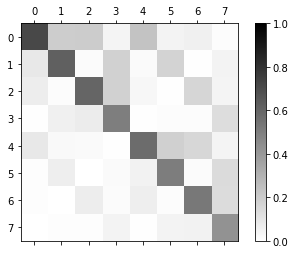

In [8]:
#Plot the calibration matrix
meas_cal.plot_calibration()

## Correct Measurement Noise on a 3Q GHZ State

In [9]:
#make a 3Q GHZ state
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])

qobj = qiskit.compile([ghz], backend=backend, shots=5000)
job = backend.run(qobj, noise_model=noise_model)
results = job.result()

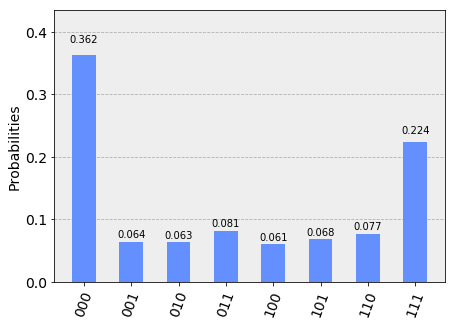

In [10]:
#results without correction
plot_histogram(results.get_counts(0))

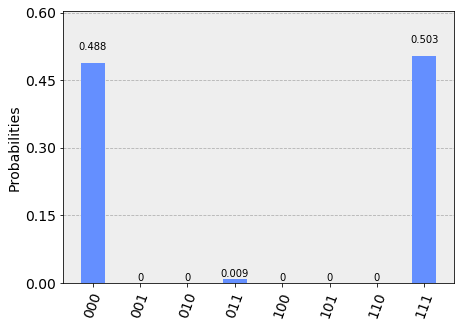

In [12]:
#results with correction
plot_histogram(meas_cal.apply(results.get_counts(0), method='least_squares'))